# 04. Transfer Learning with TensorFlow Part 1: Feature Extraction

**Transfer learning**, in other words, taking the patterns (or weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has **already learned** patterns on similar data to our own. This often results in achieving great results with less custom data, and it's time saver.

Instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as [ImageNet](http://www.image-net.org/) (millions of images of different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

Over the next few notebooks, we'll see the power of transfer learning in action.

## What we're going to cover

We're going to go through the following with TensorFlow:

- Introduce transfer learning (a way to beat all of our old self-built models)
- Using a smaller dataset to experiment faster (10% of training samples of 10 classes of food)
- Build a transfer learning feature extraction model using TensorFlow Hub
- Introduce the TensorBoard callback to track model training results
- Compare model results using TensorBoard

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
def plot_history(history, zoom=0):
    df = pd.DataFrame(history.history)
    n = len(df.columns)

    row = 1 if n<=3 else n//2
    col = n if n<=3 else n//2 + n%2

    plt.figure(figsize=(5*(col+1) + zoom , 5*row + zoom))
    for i, column in enumerate(df.columns):
        plt.subplot(row, col+1, i+1)
        plt.plot(df[f"{column}"], label=f"{column}")
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel(f"{column}")
        plt.tight_layout(pad=2) # padding
    
    plt.subplot(row, col+1, n+1)
    for column in df.columns:
        plt.plot(df[f"{column}"], label=f"{column}")
        plt.legend()
    plt.xlabel("epochs")

## Transfer leanring with TensorFlow Hub: Getting great results with 10% of the data

For many of the problems you'll want to use deep learning for, chances are, a working model already exists. <br>
And the good news is, you can access many of them on TensorFlow Hub.

[TensorFlow Hub](https://tfhub.dev/) is a repository for existing model components. It makes it so you can import and use a fully trained model with as little as a URL.

**Transfer learning often allows you to get great results with less data.**

But don't just take my word for it. Let's download a subset of the data we've been using, namely 10% of the training data from the `10_food_classes` dataset and use it to train a food image classifier on.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-transfer-learning-feature-extraction.png)
*What we're working towards building. Taking a pre-trained model and adding our own custom layers on top, extracting all of the underlying patterns learned on another dataset our own images.*



In [3]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-10-24 08:14:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 108.177.119.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   220MB/s    in 0.7s    

2022-10-24 08:14:41 (220 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [4]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

## Preprocessing 

In [5]:
from pathlib import Path 

cur_dir = Path().cwd()
food_dir = cur_dir / "10_food_classes_10_percent"
train_dir = food_dir / "train"
test_dir = food_dir / "test"

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

train_set = image_dataset_from_directory(train_dir, label_mode="categorical") # by defautl convert all images to be 256 x 256
test_set = image_dataset_from_directory(test_dir, label_mode="categorical") # image need to be rescale, currently 0-255

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Or if we wanted to see an example batch of data, we could use the `take()` method. 

In [7]:
train_set.class_names

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [8]:
preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(256, 256),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2, fill_mode="constant"), 
    tf.keras.layers.RandomZoom((-0.2, -0.4)) # A positive value means zooming out, while a negative value means zooming in
])

## Setting up callbacks

New concept : **callbacks**.

[Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:
* [**Experiment tracking with TensorBoard**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - log the performance of multiple models and then view and compare these models in a visual way on [TensorBoard](https://www.tensorflow.org/tensorboard) (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* [**Model checkpointing**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* [**Early stopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.


The TensorBoard callback can be accessed using [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard). 

Its main functionality is saving a model's training performance metrics to a specified `log_dir`.

By default, logs are recorded every epoch using the `update_freq='epoch'` parameter. This is a good default since tracking model performance too often can slow down model training.



In [9]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = Path().cwd() / dir_name / experiment_name / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  return tensorboard_callback

## Creating models using TensorFlow Hub

[TensorFlow Hub](https://tfhub.dev/).

We're going to use two models from TensorFlow Hub:
1. [ResNetV2](https://arxiv.org/abs/1603.05027) -  a state of the art computer vision model architecture from 2016.
2. [EfficientNet](https://arxiv.org/abs/1905.11946) - a state of the art computer vision architecture from 2019.

State of the art means that at some point, both of these models have achieved the lowest error rate on [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), the gold standard of computer vision benchmarks.

To find model on Tensorflow hub, here the step:

1. Go to [tfhub.dev](https://tfhub.dev/).
2. Choose your problem domain (e.g. "Image").
3. Select your TF version, which in our case is TF2.
4. Remove all "Problem domanin" filters except for the problem you're working on. 
  * **Note:** "Image feature vector" can be used alongside almost any problem, we'll get to this soon.
5. The models listed are all models which could potentially be used for your problem.

> 🤔 **Question:** *I see many options for image classification models, how do I know which is best?*

>You can see a list of **state of the art models** on [paperswithcode.com](https://www.paperswithcode.com), a resource for collecting the latest in deep learning paper results which have code implementations for the findings they report.

6. Select the Architecture tab on TensorFlow Hub and you'll see a dropdown menu of architecture names appear. 
  * The rule of thumb here is generally, names with larger numbers means better performing models. For example, EfficientNetB4 performs better than EfficientNetB0.
    * However, the tradeoff with larger numbers can mean they take longer to compute. 
7. Select EfficientNetB0 and you should see [something like the following](https://tfhub.dev/s?module-type=image-classification,image-feature-vector&network-architecture=efficientnet-b0&tf-version=tf2):
![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-tensorflow-hub-efficientnetb0.png)
8. Clicking the one titled "[efficientnet/b0/feature-vector](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1)" brings us to a page with a button that says "Copy URL". That URL is what we can use to harness the power of EfficientNetB0.
  * Copying the URL should give you something like this: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

> 🤔 **Question:** *I thought we were doing image classification, why do we choose feature vector and not classification?*

Great observation. This is where the differnet types of transfer learning come into play, as is, feature extraction and fine-tuning.

1. **"As is" transfer learning** is when you take a pretrained model as it is and apply it to your task without any changes. 

  * For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class). 

    * This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with `"/classification"` in their name on TensorFlow Hub provide this kind of functionality.

2. **Feature extraction transfer learning** is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem. 

  * For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that **only the top few layers become trainable, the rest remain frozen**. 

    * This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.

3. **Fine-tuning transfer learning** is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem. 

    * This usually means training **some, many or all** of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (**feature extraction**).

After you've trained the top 2-3 layers, you can then gradually "unfreeze" more and more layers and run the training process on your own data to further **fine-tune** the pretrained model.

> 🤔 **Question:** *Why train only the top 2-3 layers in feature extraction?*

The lower a layer is in a computer vision model as in, the closer it is to the input layer, the larger the features it learn. For example, a bottom layer in a computer vision model to identify images of cats or dogs might learn the outline of legs, where as, layers closer to the output might learn the shape of teeth. Often, you'll want the larger features (learned patterns are also called features) to remain, since these are similar for both animals, where as, the differences remain in the more fine-grained features.


In [10]:
import tensorflow_hub as hub

Now we'll get the feature vector URLs of two common computer vision architectures, [EfficientNetB0 (2019)](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1) and [ResNetV250 (2016)](https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4) from TensorFlow Hub using the steps above.

We're getting both of these because we're going to compare them to see which performs better on our data.

> **Update:** As of 14 August 2021, [EfficientNet V2 pretrained models are available on TensorFlow Hub](https://tfhub.dev/google/collections/efficientnet_v2/1). The original code in this notebook uses EfficientNet V1, it has been left unchanged. In [my experiments with this dataset](https://github.com/mrdbourke/tensorflow-deep-learning/discussions/166), V1 outperforms V2. Best to experiment with your own data and see what suits you.

In [11]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# New: EfficientNetB0 feature vector (version 2)
efficientnet_V2_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [12]:
def create_model(model_url, num_classe):
    feature_extractor_layer = hub.KerasLayer(model_url, 
                                             trainable=False, # freeze the underlying patterns
                                             name="feature_extractor_layer")
    
    activation = "softmax" if num_classe > 1 else "sigmoid"
    model = tf.keras.Sequential([
        preprocessing,
        feature_extractor_layer,
        tf.keras.layers.Dense(num_classe, activation=activation, name="output_layer")
    ])

    return model

In [13]:
num_classe = len(class_names)
num_classe

10

## ResNetV250 model

In [14]:
resnet_model = create_model(resnet_url, num_classe)

resnet_model.compile(loss="categorical_crossentropy",
                     optimizer="adam",
                     metrics=["acc"])

In [15]:
resnet_callback = create_tensorboard_callback("tensorflow_hub", "resnet")

resnet_history = resnet_model.fit(train_set, 
                                  epochs=10, 
                                  validation_data=test_set, 
                                  callbacks=[resnet_callback])

Epoch 1/10
24/24 [==============================] - 29s 709ms/step - loss: 2.1549 - acc: 0.2560 - val_loss: 1.3766 - val_acc: 0.5776
Epoch 2/10
24/24 [==============================] - 14s 586ms/step - loss: 1.2933 - acc: 0.6253 - val_loss: 0.9598 - val_acc: 0.7216
Epoch 3/10
24/24 [==============================] - 14s 599ms/step - loss: 0.9596 - acc: 0.7200 - val_loss: 0.8111 - val_acc: 0.7536
Epoch 4/10
24/24 [==============================] - 15s 607ms/step - loss: 0.8133 - acc: 0.7467 - val_loss: 0.7445 - val_acc: 0.7756
Epoch 5/10
24/24 [==============================] - 14s 583ms/step - loss: 0.7008 - acc: 0.7920 - val_loss: 0.7182 - val_acc: 0.7632
Epoch 6/10
24/24 [==============================] - 14s 585ms/step - loss: 0.6573 - acc: 0.7987 - val_loss: 0.6839 - val_acc: 0.7804
Epoch 7/10
24/24 [==============================] - 14s 599ms/step - loss: 0.5934 - acc: 0.8253 - val_loss: 0.6459 - val_acc: 0.7944
Epoch 8/10
24/24 [==============================] - 14s 592ms/step - 

In [28]:
resnet_score = resnet_model.evaluate(test_set)

79/79 [==============================] - 10s 125ms/step - loss: 0.6384 - acc: 0.7932


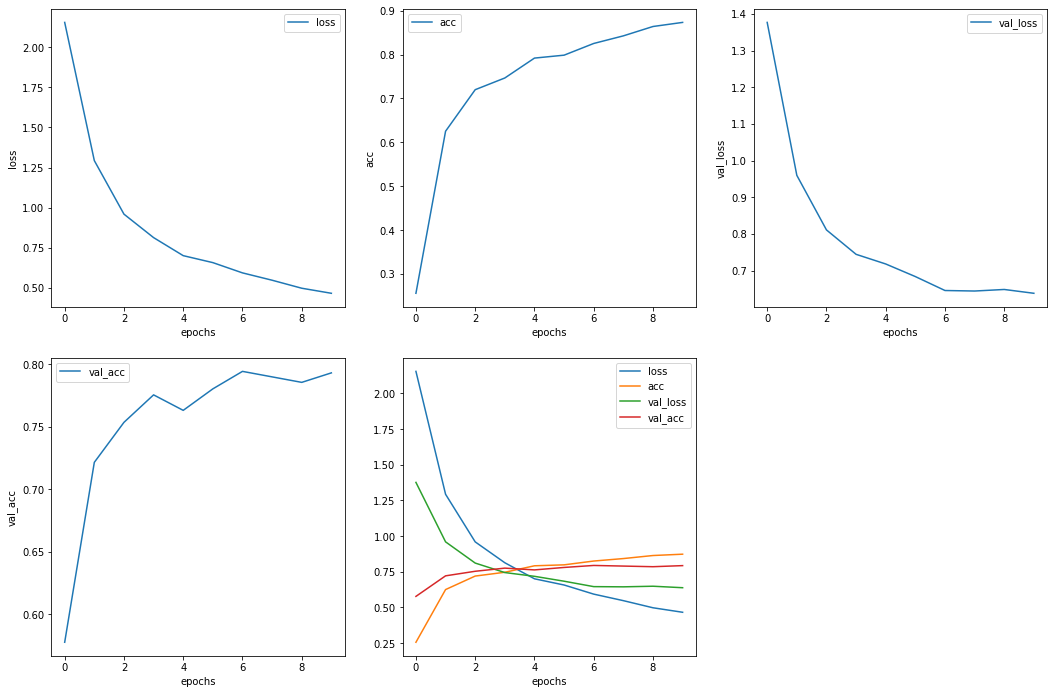

In [16]:
plot_history(resnet_history)

In [17]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## EfficientNetB0 model

**Okay, we've trained a ResNetV250 model, time to do the same with EfficientNetB0 model**



In [19]:
efficientnet_model = create_model(efficientnet_url, num_classe)

efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer="adam",
                           metrics=["acc"])

efficientnet_callback = create_tensorboard_callback("tensorflow_hub", "efficientnet")

In [20]:
efficientnet_history = efficientnet_model.fit(train_set,
                                              epochs=10, 
                                              validation_data=test_set, 
                                              callbacks=[efficientnet_callback])

Epoch 1/10
24/24 [==============================] - 30s 627ms/step - loss: 1.9254 - acc: 0.3880 - val_loss: 1.3734 - val_acc: 0.7216
Epoch 2/10
24/24 [==============================] - 15s 605ms/step - loss: 1.2771 - acc: 0.7120 - val_loss: 0.9592 - val_acc: 0.7976
Epoch 3/10
24/24 [==============================] - 10s 425ms/step - loss: 0.9848 - acc: 0.7613 - val_loss: 0.7675 - val_acc: 0.8348
Epoch 4/10
24/24 [==============================] - 11s 453ms/step - loss: 0.8166 - acc: 0.8053 - val_loss: 0.6672 - val_acc: 0.8504
Epoch 5/10
24/24 [==============================] - 11s 429ms/step - loss: 0.7162 - acc: 0.8347 - val_loss: 0.5997 - val_acc: 0.8596
Epoch 6/10
24/24 [==============================] - 12s 502ms/step - loss: 0.6566 - acc: 0.8507 - val_loss: 0.5596 - val_acc: 0.8612
Epoch 7/10
24/24 [==============================] - 11s 451ms/step - loss: 0.5983 - acc: 0.8480 - val_loss: 0.5283 - val_acc: 0.8668
Epoch 8/10
24/24 [==============================] - 12s 493ms/step - 

In [27]:
efficientnet_score = efficientnet_model.evaluate(test_set)

79/79 [==============================] - 7s 87ms/step - loss: 0.4682 - acc: 0.8764


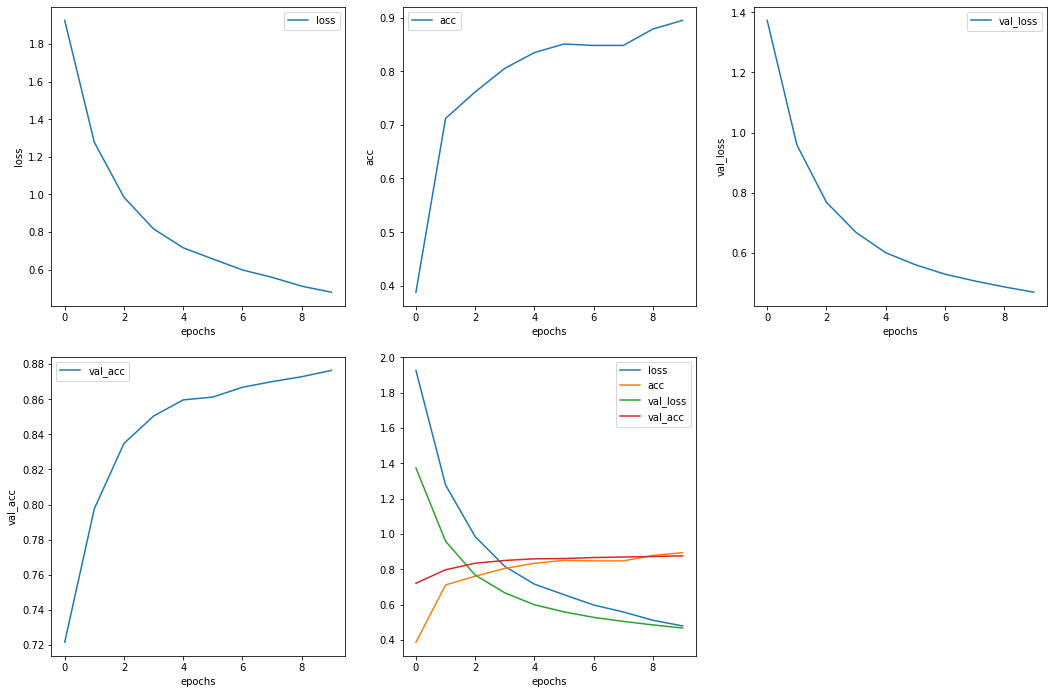

In [21]:
plot_history(efficientnet_history)

In [22]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## EfficientNetB0 V2 model

In [23]:
efficientnet_V2_model = create_model(efficientnet_V2_url, num_classe)

efficientnet_V2_model.compile(loss="categorical_crossentropy",
                           optimizer="adam",
                           metrics=["acc"])

efficientnet_V2_callback = create_tensorboard_callback("tensorflow_hub", "efficientnet_V2")

In [24]:
efficientnet_V2_history = efficientnet_V2_model.fit(train_set,
                                                    epochs=10, 
                                                    validation_data=test_set, 
                                                    callbacks=[efficientnet_V2_callback])

Epoch 1/10
24/24 [==============================] - 29s 659ms/step - loss: 2.0971 - acc: 0.2680 - val_loss: 1.7558 - val_acc: 0.4860
Epoch 2/10
24/24 [==============================] - 14s 576ms/step - loss: 1.6198 - acc: 0.5227 - val_loss: 1.3897 - val_acc: 0.6520
Epoch 3/10
24/24 [==============================] - 10s 403ms/step - loss: 1.3754 - acc: 0.6147 - val_loss: 1.1950 - val_acc: 0.6888
Epoch 4/10
24/24 [==============================] - 10s 399ms/step - loss: 1.2350 - acc: 0.6547 - val_loss: 1.0755 - val_acc: 0.7056
Epoch 5/10
24/24 [==============================] - 11s 468ms/step - loss: 1.1155 - acc: 0.6880 - val_loss: 0.9981 - val_acc: 0.7236
Epoch 6/10
24/24 [==============================] - 9s 386ms/step - loss: 1.0658 - acc: 0.6813 - val_loss: 0.9400 - val_acc: 0.7344
Epoch 7/10
24/24 [==============================] - 10s 400ms/step - loss: 0.9743 - acc: 0.7080 - val_loss: 0.8890 - val_acc: 0.7448
Epoch 8/10
24/24 [==============================] - 9s 379ms/step - lo

In [29]:
efficientnet_V2_score = efficientnet_V2_model.evaluate(test_set)

79/79 [==============================] - 7s 81ms/step - loss: 0.8035 - acc: 0.7588


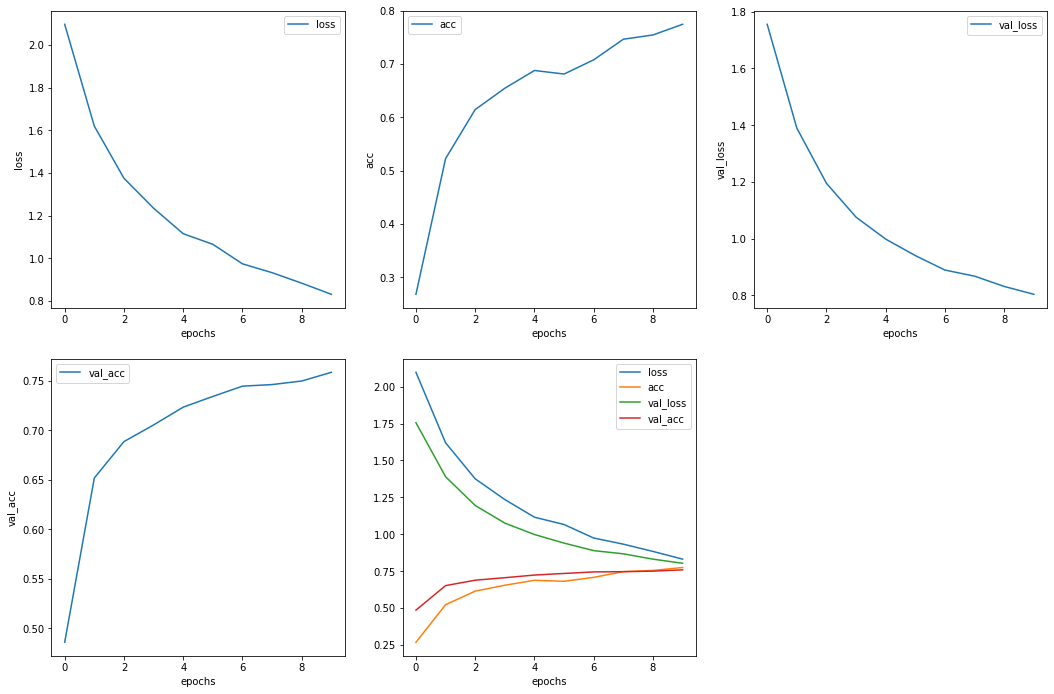

In [25]:
plot_history(efficientnet_V2_history)

In [26]:
efficientnet_V2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 feature_extractor_layer (Ke  (None, 1280)             5919312   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


## Comparing

### Quick comparison (test score)

In [31]:
scores = [
    ["resnet", resnet_score[1]],
    ["efficientnet", efficientnet_score[1]],
    ["efficientnet_V2", efficientnet_V2_score[1]]
]

pd.DataFrame(scores, columns=["model", "model_test_score"])

,model,model_test_score
0,resnet,0.7932
1,efficientnet,0.8764
2,efficientnet_V2,0.7588


### Comparing models using TensorBoard


**Experiment tracking** [**TensorBoard**](https://www.tensorflow.org/tensorboard) (preinstalled in Google Colab).

The good thing is, since we set up a TensorBoard callback, all of our model's training logs have been saved automatically. To visualize them, we can upload the results to [TensorBoard.dev](https://tensorboard.dev/).

Uploading your results to TensorBoard.dev enables you to track and share multiple different modelling experiments. So if you needed to show someone your results, you could send them a link to your TensorBoard.dev as well as the accompanying Colab notebook.

> 🔑 **Note:** These experiments are public, do not upload sensitive data. You can delete experiments if needed.

In [32]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir tensorflow_hub

#### **Uploading experiments to TensorBoard**

To upload a series of TensorFlow logs to TensorBoard, we can use the following command:

```
Upload TensorBoard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \ 
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \ 
  --one_shot
```

Where:
* `--logdir` is the target upload directory
* `--name` is the name of the experiment
* `--description` is a brief description of the experiment
* `--one_shot` exits the TensorBoard uploader once uploading is finished

Running the `tensorboard dev upload` command will first ask you to authorize the upload to TensorBoard.dev. After you've authorized the upload, your log files will be uploaded.

In [35]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. EfficientNetB0 V2 vs. ResNet50V2" \
  --description "Comparing three different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) y

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=wEVsdAeR00FOJ6sOhcVfEevBdaDdmQ&prompt=consent&access_type=offli

Every time you upload something to TensorBoad.dev you'll get a new experiment ID. <br>
> Ex : https://tensorboard.dev/experiment/BuDCyVjKQI6M7rfk05jyCg/

If you upload the same directory again, you'll get a new experiment ID to go along with it.

This means to track your experiments, you may want to look into how you name your uploads. That way when you find them on TensorBoard.dev you can tell what happened during each experiment (e.g. "efficientnet0_10_percent_data").

#### Listing experiments you've saved to TensorBoard

To see all of the experiments you've uploaded you can use the command:

```tensorboard dev list```

In [36]:
# Check out experiments
!tensorboard dev list

https://tensorboard.dev/experiment/BuDCyVjKQI6M7rfk05jyCg/
	Name                 EfficientNetB0 vs. EfficientNetB0 V2 vs. ResNet50V2
	Description          Comparing three different TF Hub feature extraction models architectures using 10% of training images
	Id                   BuDCyVjKQI6M7rfk05jyCg
	Created              2022-10-24 09:01:38 (2 minutes ago)
	Updated              2022-10-24 09:01:48 (2 minutes ago)
	Runs                 13
	Tags                 5
	Scalars              252
	Tensor bytes         0
	Binary object bytes  14372721
Total: 1 experiment(s)


#### Deleting experiments from TensorBoard

Remember, all uploads to TensorBoard.dev are public, so to delete an experiment you can use the command:

`tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID]`



In [37]:
# Delete an experiment
!tensorboard dev delete --experiment_id BuDCyVjKQI6M7rfk05jyCg

Deleted experiment BuDCyVjKQI6M7rfk05jyCg.


In [38]:
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.


## 📖 Extra-curriculum

* Read through the [TensorFlow Transfer Learning Guide](https://www.tensorflow.org/tutorials/images/transfer_learning) and define the main two types of transfer learning in your own words.
* Go through the [Transfer Learning with TensorFlow Hub tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) on the TensorFlow website and rewrite all of the code yourself into a new Google Colab notebook making comments about what each step does along the way.
* We haven't covered fine-tuning with TensorFlow Hub in this notebook, but if you'd like to know more, go through the [fine-tuning a TensorFlow Hub model tutorial](https://www.tensorflow.org/hub/tf2_saved_model#fine-tuning) on the TensorFlow homepage.How to fine-tune a tensorflow hub model:  
* Look into [experiment tracking with Weights & Biases](https://www.wandb.com/experiment-tracking), how could you integrate it with our existing TensorBoard logs?